# Goal: Create a word vector from a game of thrones dataset and analyze them to see semantic similarity

In [9]:
from __future__ import absolute_import, division, print_function

# for word encoding
import codecs

# regex
import glob

# concurrency
import multiprocessing

# operating system
import os

# pretty printing
import pprint

# regular expressions
import re

# natural language toolkit
import nltk

# word2vec
import gensim.models.word2vec as w2v

# dimensionality reduction
import sklearn.manifold

# math
import numpy as np

#plotting
import matplotlib.pyplot as plt

# pandas
import pandas as pd

# visualization
import seaborn as sns

# Step 1: process our data
### Clean data

In [10]:
nltk.download('punkt') #pre-train tokenizer (we take a piece of text and we split it in sentences (in this case))
nltk.download('stopwords') # words like and, the, an, of

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Damygame\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Damygame\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

## get the book names, matching txt file

In [15]:
book_filenames = sorted(glob.glob("./data/*.txt"))
print(book_filenames)

['./data\\got1.txt', './data\\got2.txt', './data\\got3.txt', './data\\got4.txt', './data\\got5.txt']


## Combine the books into one string

In [16]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{}'...".format(book_filename))
    with codecs.open(book_filename, 'r', 'utf-8') as book_file:
        corpus_raw += book_file.read()
    print("Corpus raw is now {} characters long".format(len(corpus_raw)))
    print()

Reading './data\got1.txt'...
Corpus raw is now 1770659 characters long

Reading './data\got2.txt'...
Corpus raw is now 4071041 characters long

Reading './data\got3.txt'...
Corpus raw is now 6391405 characters long

Reading './data\got4.txt'...
Corpus raw is now 8107945 characters long

Reading './data\got5.txt'...
Corpus raw is now 9719485 characters long



## split the corpus into sentences

In [17]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [18]:
raw_sentences = tokenizer.tokenize(corpus_raw)

## contert the sentences into a list of words

In [24]:
# remove unnecessary , split into words, no hyphens
# list of words
def sentence_to_wordlist(raw):
    clean = re.sub('[^a-zA-Z]', ' ', raw)
    words = clean.split()
    return words

# sentences where each word is tokenized
sentences = []

for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [25]:
print(raw_sentences[60])
print(sentences[60])

He let the younger man settle him behind his books and papers.
['He', 'let', 'the', 'younger', 'man', 'settle', 'him', 'behind', 'his', 'books', 'and', 'papers']


In [26]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,818,103 tokens


# Step 2: Build Word2Vec

## Word Embedding

![Linear relationships](./images/linear-relationships.png)

### Once we have vectors, 3 main tasks that vectors help with:
- DISTANCE
- SIMILARITY
- RANKING

### Hyperparameters

In [27]:
# Dimensionality of the resulting word vectors
# the more dimensions, more computationally expensive to train, 
# but also more accurate
# more dimensions = more generalized
num_features = 300

# minimum word count threshold
min_word_count = 3

# number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# contexxt window length
context_size = 7

# Downsample setting for frequent words
# 0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for random number generator, to make the result reproducible.
# deterministic, good for debugging
seed = 1

## Actual model using gensim
Docstring:     
Class for training, using and evaluating neural networks described in https://code.google.com/p/word2vec/

- `sg` defines the training algorithm. By default (`sg=0`), CBOW is used.
Otherwise (`sg=1`), skip-gram is employed.

- `size` is the dimensionality of the feature vectors.

- `window` is the maximum distance between the current and predicted word within a sentence.

- `seed` = for the random number generator. Initial vectors for each
word are seeded with a hash of the concatenation of word + str(seed).
Note that for a fully deterministically-reproducible run, you must also limit the model to
a single worker thread, to eliminate ordering jitter from OS thread scheduling. (In Python
3, reproducibility between interpreter launches also requires use of the PYTHONHASHSEED
environment variable to control hash randomization.)

- `min_count` = ignore all words with total frequency lower than this.

- `sample` = threshold for configuring which higher-frequency words are randomly downsampled;
    default is 1e-3, useful range is (0, 1e-5).

- `workers` = use this many worker threads to train the model (=faster training with multicore machines).

In [29]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [30]:
thrones2vec.build_vocab(sentences)

# Step 3: Train the model

In [42]:
thrones2vec.train(sentences, total_examples=thrones2vec.corpus_count, epochs=thrones2vec.iter)

7022606

### Save to file

In [43]:
if not os.path.exists("trained"):
    os.makedirs("trained")
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

# Step 4: Explore the trained model

In [44]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

## Compress the word vectors into 2D space and plot them

In [54]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = thrones2vec.wv.syn0

## train t-SNE

In [55]:
all_word_vectors_matrix = tsne.fit_transform(all_word_vectors_matrix)

## Plotting

In [56]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=['word','x','y']

)

In [57]:
points.head()

,word,x,y
0,This,35.074322,-20.768278
1,edition,-52.302761,-33.324509
2,the,12.780417,-62.605156
3,complete,-3.275613,-21.549831
4,of,-3.457767,-1.605427


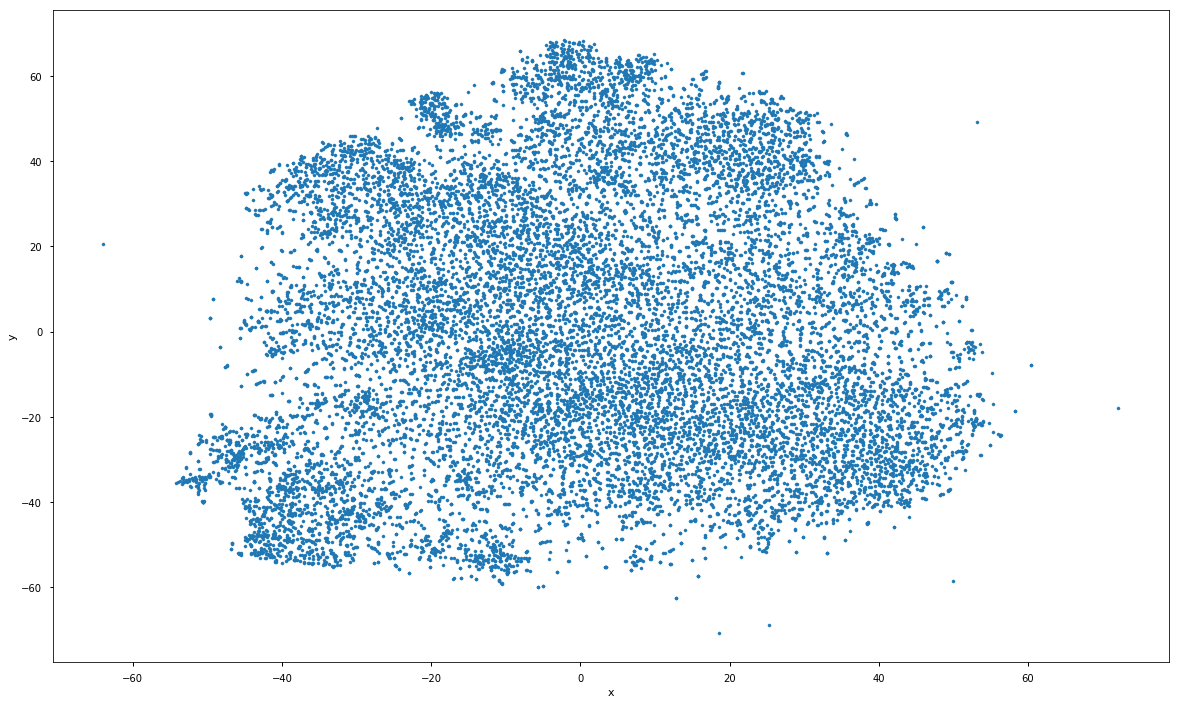

In [87]:
sns.set_context('notebook')
points.plot.scatter('x', 'y', s=10, figsize=(20,12))
plt.show()

#### zoom in to some interesting places

In [97]:
def plot_region(x_bounds, y_bounds):
    slices = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])       
    ]
    sns.set_context('notebook')
    ax = slices.plot.scatter('x', 'y', s=35, figsize=(10,8))
    for i, point in slices.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
    plt.show()

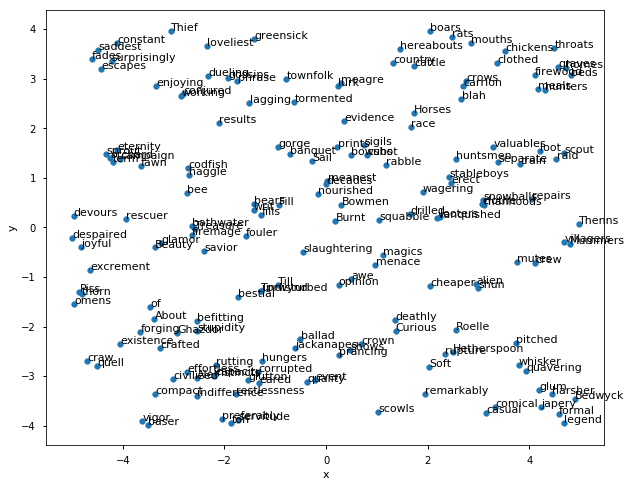

In [103]:
plot_region(x_bounds=(-5,5), y_bounds=(-4, 4))

In [104]:
thrones2vec.most_similar('Stark')

[('Eddard', 0.720142126083374),
 ('Winterfell', 0.6703850030899048),
 ('Lyanna', 0.643958330154419),
 ('Robb', 0.63763028383255),
 ('Starks', 0.6312656402587891),
 ('direwolf', 0.6281445026397705),
 ('beheaded', 0.6223097443580627),
 ('Hornwood', 0.6200913786888123),
 ('executed', 0.6194355487823486),
 ('Benjen', 0.6161108613014221)]

In [105]:
thrones2vec.most_similar('Aerys')

[('Jaehaerys', 0.7772444486618042),
 ('Daeron', 0.7730696201324463),
 ('Mad', 0.7636208534240723),
 ('reign', 0.7343382239341736),
 ('Usurper', 0.7293753623962402),
 ('rebellion', 0.7186369299888611),
 ('Elia', 0.7121650576591492),
 ('II', 0.7116929292678833),
 ('Rhaegar', 0.7106436491012573),
 ('Beggar', 0.7099664807319641)]

In [106]:
thrones2vec.most_similar('direwolf')

[('wolf', 0.6933640241622925),
 ('Rickon', 0.6482281684875488),
 ('Ghost', 0.6313973665237427),
 ('Stark', 0.6281445026397705),
 ('crannogman', 0.6258572340011597),
 ('pup', 0.6249077320098877),
 ('SHAGGYDOG', 0.6230602264404297),
 ('Winterfell', 0.6114803552627563),
 ('GHOST', 0.608173131942749),
 ('eagle', 0.6042563915252686)]

In [107]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")

Stark is related to Winterfell, as Tully is related to Riverrun


'Tully'

In [108]:
nearest_similarity_cosmul("Jaime", "sword", "wine")

Jaime is related to sword, as cup is related to wine


'cup'

In [109]:
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Arya is related to Nymeria, as Dany is related to dragons


'Dany'